In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from matplotlib.colors import LogNorm

from SimPEG import Mesh, Maps
from SimPEG.EM import TDEM

from pymatsolver import Pardiso

# import empymod for comparison
from empymod import bipole

# interaction
import ipywidgets as widgets

%matplotlib inline

In [2]:
rcParams["font.size"] = 12

### define layered model

In [3]:
rho_h_layers = np.r_[1e8, 100, 5, 100]
rho_v_layers = np.r_[1e8, 100, 20, 100]

layer_tops = np.r_[0, -100, -500]  # z-positive up in SimPEG

### survey parameters

In [4]:
src_a = np.r_[0., 0., 0.]
src_b = np.r_[0., 400., 0.]

rx_loc = np.r_[1000, 0., 0.]

rx_times = np.logspace(np.log10(5e-4), 0, 200)

### Set up a mesh

In [5]:
# check the diffusion distance 

def diffusion_distance(rho, t):
    return 1260*np.sqrt(t*rho)

print(f"The diffusion distance is {diffusion_distance(rho_v_layers[-1], rx_times[-1]):1.0e}m")

The diffusion distance is 1e+04m


In [6]:
# cell widths in the core region of the mesh
hx = 100
hy = 100
hz = 50

# extent of the core region of the mesh (uniform cell sizes)
n_core_x = int(np.ceil(rx_loc[0]/hx)) + 2
n_core_y = n_core_x
n_core_z = int(np.ceil(-layer_tops[-1]/hz))

# number of padding cells in each dimension
npadx = 11
npady = 11
npadz = 12

# padding factor
pad_factor = 1.5

In [7]:
npadz+n_core_z

22

In [8]:
mesh = Mesh.TensorMesh([
    [(hx, npadx, -pad_factor), (hx, n_core_x), (hx, npadx, pad_factor)],
    [(hy, npady, -pad_factor), (hy, n_core_y), (hy, npady, pad_factor)],
    [(hz, npadz, -pad_factor), (hz, n_core_z), (hz, npadz, pad_factor)],
])

mesh.x0 = np.r_[
    -mesh.hx[:npadx+1].sum(), 
    -mesh.hy[:npady+1].sum(), 
    -mesh.hz[:(npadz+n_core_z)].sum()
]

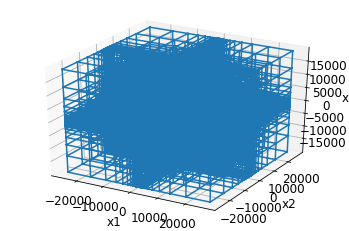

In [9]:
mesh.plotGrid()

In [10]:
print(f"There are {mesh.nC} cells in the mesh")

There are 39304 cells in the mesh


### put the model on the mesh

In [11]:
rho_h = rho_h_layers[0] * np.ones(mesh.nC)
rho_v = rho_v_layers[0] * np.ones(mesh.nC)

for i, l in enumerate(layer_tops):
    z_inds = (mesh.gridCC[:, 2] <= l)
    rho_h[z_inds] = rho_h_layers[i + 1]
    rho_v[z_inds] = rho_v_layers[i + 1]

rho_aniso = np.vstack([rho_h, rho_h, rho_v]).T

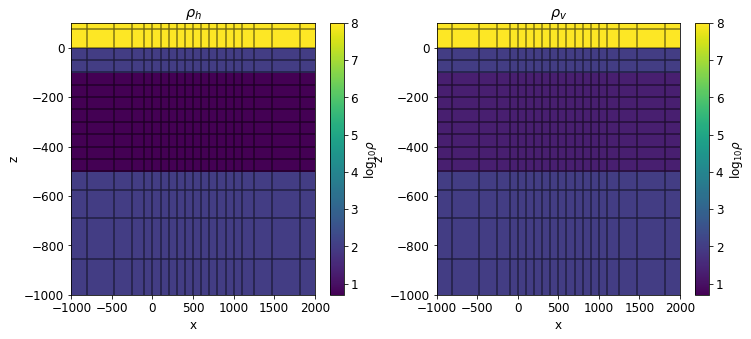

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
xlim = np.r_[-1000, 2000]
zlim = np.r_[-1000, 100]


for a, model, title in zip(ax, [rho_h, rho_v], ["$\\rho_h$", "$\\rho_v$"]): 
    
    plt.colorbar(
        mesh.plotSlice(np.log10(model), normal='y', ax=a, grid=True, clim=[np.log10(5), 8])[0], 
        ax=a, label="$\log_{10}\\rho$"
    )
    
    a.set_xlim(xlim)
    a.set_ylim(zlim)
    a.set_title(title)

## Set up the survey

In [13]:
rx = TDEM.Rx.Point_e(rx_loc, times=rx_times, orientation="x")
src = TDEM.Src.LineCurrent([rx], loc=np.vstack([src_a, src_b]))  # default waveform is a step-off

In [14]:
prob_times = [(1e-6, 20), (1e-5, 20), (3e-5, 20), (1e-4, 30), (1e-3, 30), (1e-2, 30), (3e-2, 30)]

In [15]:
# isotropic problem 
survey_iso = TDEM.Survey([src])
prob_iso = TDEM.Problem3D_e(
    mesh, rhoMap=Maps.IdentityMap(mesh), timeSteps=prob_times, Solver=Pardiso, 
    verbose=True
)
prob_iso.pair(survey_iso)

In [16]:
# anisotropic problem 
survey_aniso = TDEM.Survey([src])
prob_aniso = TDEM.Problem3D_e(
    mesh, rhoMap=Maps.IdentityMap(nP=mesh.nC), timeSteps=prob_times, Solver=Pardiso, 
    verbose=True
)
prob_aniso.pair(survey_aniso)

## Compute the fields

In [17]:
%%time
fields_iso = prob_iso.fields(rho_h)

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

In [18]:
%%time
fields_aniso = prob_aniso.fields(rho_aniso)

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

## compute the data

In [19]:
dpred_iso = survey_iso.dpred(rho_h, f=fields_iso)

In [20]:
dpred_aniso = survey_aniso.dpred(rho_aniso, f=fields_aniso)

## Plot the fields

In [21]:
def plot_currents(model, time_ind, loc_ind, xmin, xmax, ymin, ymax, normal="X", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        
    if model == "iso":
        currents = fields_iso[:, "j", time_ind]
    elif model == "aniso":
        currents = fields_aniso[:, "j", time_ind]
    
    
    plt.colorbar(mesh.plotSlice(
        currents, view="vec", vType="E", normal=normal, ind=loc_ind, 
        range_x=[xmin, xmax], range_y=[ymin, ymax], ax=ax, 
    )[0])
    
    ax.set_aspect(1)
        

In [22]:
widgets.interact(
    plot_currents, 
    model=widgets.ToggleButtons(options=["iso", "aniso"]),
    time_ind=widgets.IntSlider(min=0, max=prob_iso.nT, value=0), 
    loc_ind=widgets.IntSlider(min=0, max=mesh.vnC.max(), value=npadx),
    xmin=widgets.FloatText(value=-1000.), 
    xmax=widgets.FloatText(value=2000.),
    ymin=widgets.FloatText(value=-1000.), 
    ymax=widgets.FloatText(value=0.),
    normal=widgets.ToggleButtons(options=["X", "Y", "Z"]),
    ax=widgets.fixed(None)
)


interactive(children=(ToggleButtons(description='model', options=('iso', 'aniso'), value='iso'), IntSlider(val…

<function __main__.plot_currents(model, time_ind, loc_ind, xmin, xmax, ymin, ymax, normal='X', ax=None)>

## Plot the data

In [23]:
def plot_data(data, ax, plot_type="semilogy", color="C0", label=None):
    getattr(ax, plot_type)(rx_times, data, color, label=label)
    
    if plot_type in ["semilogy", "loglog"]:
        getattr(ax, plot_type)(rx_times, -data, color+"--")

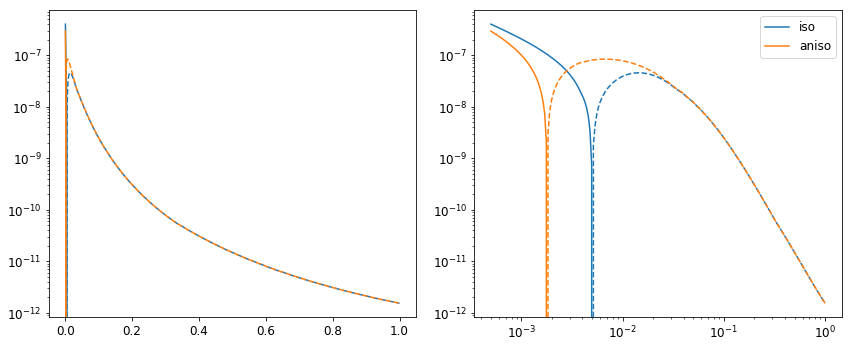

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_data(dpred_iso, ax=ax[0], plot_type="semilogy", color="C0", label="iso")
plot_data(dpred_aniso, ax=ax[0], plot_type="semilogy", color="C1", label="aniso")

plot_data(dpred_iso, ax=ax[1], plot_type="loglog", color="C0", label="iso")
plot_data(dpred_aniso, ax=ax[1], plot_type="loglog", color="C1", label="aniso")

ax[1].legend()


plt.tight_layout()

## Compare with empymod

In [25]:
inp6 = {'src': [0, 0, 0.01, 400, 0, 0.01], #source at origin, .01 m z
        'rec': [1000, 0, 0.01, 0, 0], #source at x=1000, .01m z
        'depth': -layer_tops,
        'freqtime': rx_times, 
        'signal': -1, #Switch off
        'verb': 0} #How much info output

# Isotropic case
empymod_iso = bipole(res=rho_h_layers, aniso=[1, 1, 1, 1], **inp6)

# Keep horizontal resistivity constant
aniso_lay=[np.sqrt(rho_v_layers[ii]/rho_h_layers[ii]) for ii in range(0,len(rho_h_layers))] #Calculate aniso
empymod_aniso = bipole(res=rho_h_layers, aniso=aniso_lay, **inp6)

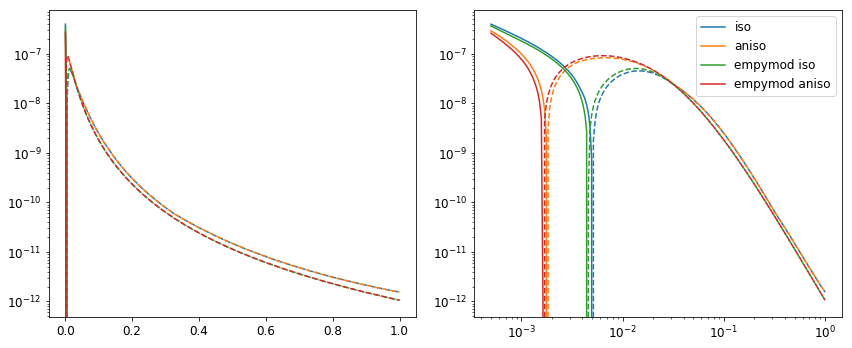

In [26]:
wire_length = 400

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_data(dpred_iso, ax=ax[0], plot_type="semilogy", color="C0", label="iso")
plot_data(dpred_aniso, ax=ax[0], plot_type="semilogy", color="C1", label="aniso")

plot_data(empymod_iso*wire_length, ax=ax[0], plot_type="semilogy", color="C2", label="empymod iso")
plot_data(empymod_aniso*wire_length, ax=ax[0], plot_type="semilogy", color="C3", label="empymod aniso")

plot_data(dpred_iso, ax=ax[1], plot_type="loglog", color="C0", label="iso")
plot_data(dpred_aniso, ax=ax[1], plot_type="loglog", color="C1", label="aniso")

plot_data(empymod_iso*wire_length, ax=ax[1], plot_type="loglog", color="C2", label="empymod iso")
plot_data(empymod_aniso*wire_length, ax=ax[1], plot_type="loglog", color="C3", label="empymod aniso")

ax[1].legend()

plt.tight_layout()